In [1]:
#Import necissary libraries, see readMe installations for additional guidance
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


2025-04-26 09:21:49.903538: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
'''
Load the MetMeuseumData.csv into the dataframe called df
'''
df = pd.read_csv('../DATA/MetMuseumData.csv')  

In [3]:
'''
In the dataframe each row represent a single art image. For each art image there is a column titled image_path which points to the appropriate image stored in the images folder found within the data folder.

This function goes through each of those images, and makes them into a processed tensor image so the image is machine readable by the model. To explore this idea more reference the "What is a tensor image" handout found within the Articles Folder.
'''
X = []
for path in df['image_path']:
    #For each image in the dataframe load the image and ensure it is the correct size the ResNet50 model expects. 
    img = load_img(path, target_size=(224, 224))  
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array) 
    X.append(img_array)

X = np.array(X)

In [4]:
'''
Store binary label encodings in the variable y, where drawings -> 1, paintings -> 0
'''
y = df['label'].values  

In [5]:
#Prepare data for training and testing with 80, 20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
#Initiation ResNet Model with input shape that matches the insput shape of images. If this process is confusing, please refer to the "Exploring ResNet50" handout as found in the Articles reference material
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid') 
])

In [7]:
# Freeze base model layers to add layers ontop
# You could consider unfreezing if you want to attempt to fine tune the model at a more granular level but this is good for the purpose of the case study
for layer in base_model.layers:
    layer.trainable = False

In [8]:
#Compile the model declared above 
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


#Setup early stopping so if model stops improving at a certain rate it will stop early before over fitting to the data when called 
early_stop = EarlyStopping(patience=3, restore_best_weights=True)


In [9]:
#Fit the model to the data with 10 epochs, feel free to experiement with this value 
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_stop])


Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.4446 - loss: 0.8290 - val_accuracy: 0.6149 - val_loss: 0.6919
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.6255 - loss: 0.6619 - val_accuracy: 0.7019 - val_loss: 0.5882
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.7235 - loss: 0.5473 - val_accuracy: 0.7702 - val_loss: 0.5101
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.7938 - loss: 0.4688 - val_accuracy: 0.8199 - val_loss: 0.4540
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.8446 - loss: 0.4314 - val_accuracy: 0.8447 - val_loss: 0.4124


In [10]:
#Evaluate the overall accuracy of the image classification model 
loss, acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {acc:.2f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8626 - loss: 0.4061
Test accuracy: 0.84


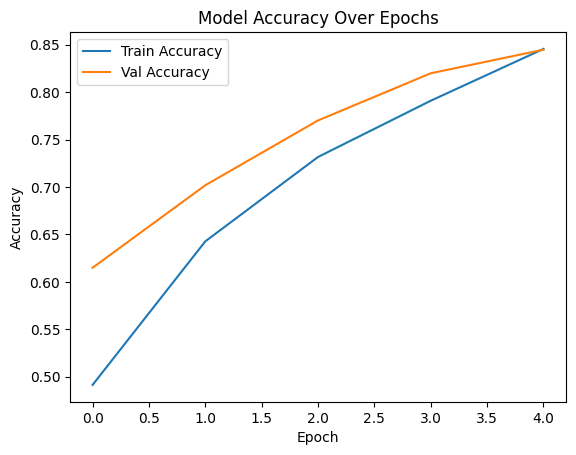

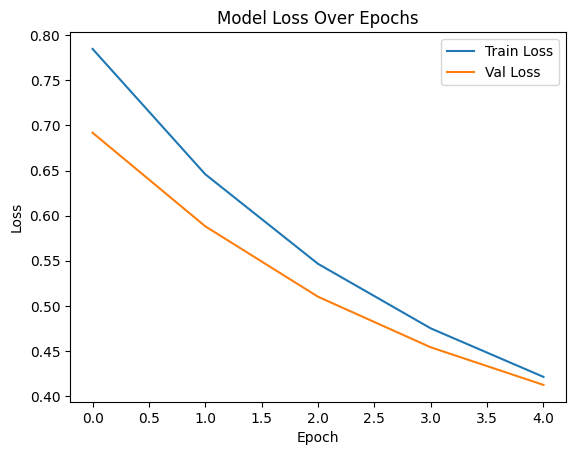

In [11]:
# Create graphs to visuazlies the performance of the model over epochs to see how it improves over time. 

#1. Accuracy Plot

#Blue Line 'Train Accuracy' showcases how well the model is performing on training data over time
plt.plot(history.history['accuracy'], label='Train Accuracy')
#Orange Line 'Val Accuracy' showcases how well the model is performing on validation data that has not been seen
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#2. Loss Plot

#Blue line 'Train Loss' measures the extent to which the model's predications are wrong on training data
plt.plot(history.history['loss'], label='Train Loss')
#Orange line 'Val loss' Measures the error as seen on the validation data 
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Feel free to experiement further? What happens if you change the number of epochs or batch size? 

How might you determine the optimal stopping point in terms of number of Epochs? 
- https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/